This PyTorch regime is based on the Deep Kolmogorov Method which employs the standard Gaussian random variables and continuous uniformly random distributed variables to determine the unique approximant of the target function over multidimension compact domains.

The following set of source code will deliver the computation of an approximate targetting function $u(t,\mathbb{x})$ where $t\in[0,2]$, $\mathbb{x}=(x_1,x_2)\in\mathbb{R}^2$. Here, the target function $u(t,\mathbb{x})$ satisfies the following partial differential equation:
\begin{align}
\frac{\partial}{\partial t}u(t,\mathbb{x})&=Δ_{\mathbb{x}}u(t,\mathbb{x})\\
u(0,\mathbb{x})&=\sin{x_1}+\sin{x_2}.
\end{align}

In [59]:
# Importing necessary and essential Python (PyTorch) assemblies.
import torch
import matplotlib.pyplot as plt
# Use the GPU if available
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [60]:
# Defining initials of fully connected feed forward Neural Network with the initial conditions (phi). This performs the computation of E[|phi(sqrt(2*rho*T) W + xi) -
# N(xi)|2].
def loss(N, rho, phi, t, x):
  W = torch.randn_like(x).to(dev)#standard Gaussian random variable
  return (phi(torch.sqrt(2 * rho * t) * W + x) -
          N(torch.cat((t,x),1))).square().mean()

In [61]:
#Set-up of the Heat Equation be registering the values of dimension, intervals length, time horizon and diffusivity
d = 2
a, b = -5.0, 5.0
T = 2.0
rho = 1.0

In [62]:
# Initial value condition for the Heat Equation
def phi(x):
  return x.sin().sum(axis=1, keepdim=True)

# Define a neural network with two hidden layers with 75 neurons
# Using ReLU activations and GELU activations
N = torch.nn.Sequential(
    torch.nn.Linear(d+1, 75), torch.nn.ReLU(),
    torch.nn.Linear(75, 75), torch.nn.GELU(),
    torch.nn.Linear(75, 1)
    ).to(dev)

In [63]:
# Configure the training parameters and optimization algorithm
steps = 3000
batch_size = 256
optimizer = torch.optim.Adam(N.parameters())

In [64]:
# Feed Forward Neural Network training
for step in range(steps):
  # Generate uniformly distributed samples from [a,b]^d
  x = (torch.rand(batch_size, d) * (b-a) + a).to(dev)
  t = T * torch.rand(batch_size , 1).to(dev)

  optimizer.zero_grad()
  # Compute the loss
  L = loss(N, rho, phi, t, x)
  # Compute the gradients
  L.backward()
  # Apply changes to weights and biases of N
  optimizer.step()

In [65]:
# Result at M+1 timesteps
M=5
mesh = 128

In [66]:
def toNumpy(t):
  return t.detach().cpu().numpy().reshape((mesh,mesh))

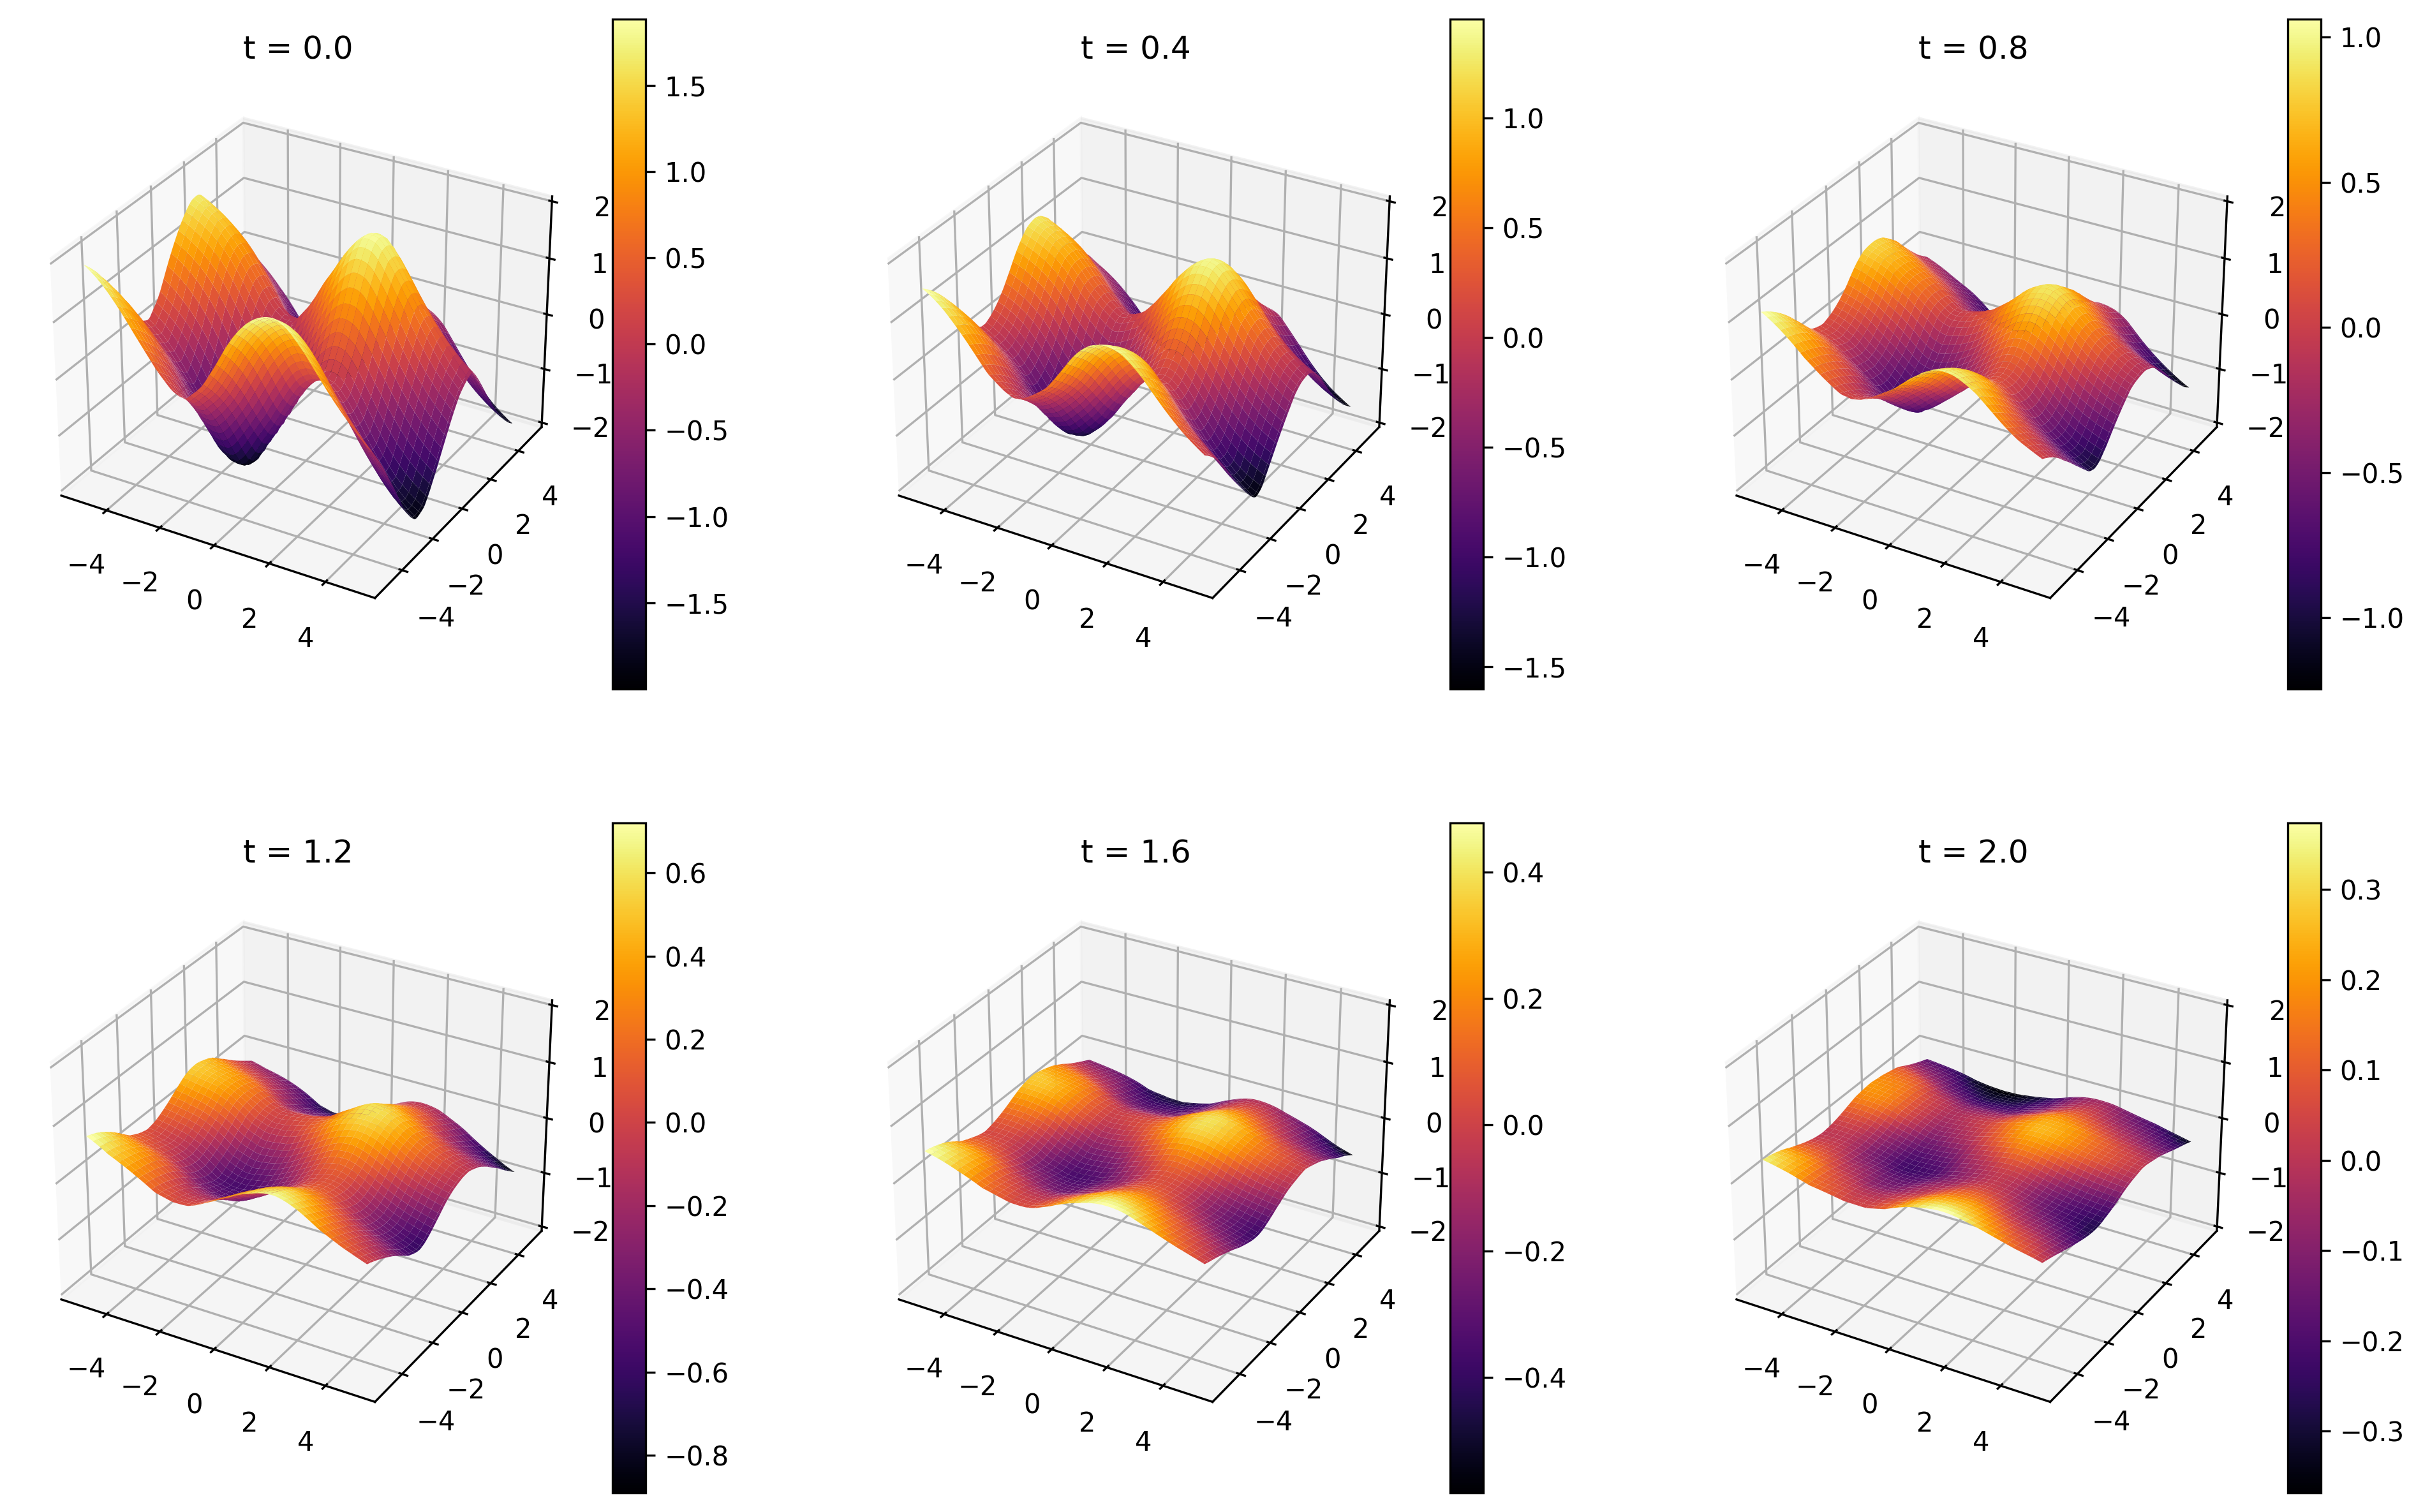

In [67]:
fig, axs = plt.subplots(2,3,subplot_kw=dict(projection='3d'))
fig.set_size_inches(16, 10)
fig.set_dpi(300)


for i in range(M+1):
  x = torch.linspace(a, b, mesh)
  y = torch.linspace(a, b, mesh)
  x, y = torch.meshgrid(x, y, indexing='xy')
  x = x.reshape((mesh*mesh ,1)).to(dev)
  y = y.reshape((mesh*mesh ,1)).to(dev)
  z = N(torch.cat((i*T/M*torch.ones(128*128,1).to(dev), x, y),
                  1))
  axs[i//3,i%3].set_title(f"t = {i * T / M}")
  axs[i//3,i%3].set_zlim(-2,2)
  HS_fig=axs[i//3,i%3].plot_surface(toNumpy(x),toNumpy(y),toNumpy(z),
                             cmap='inferno')
  plt.colorbar(HS_fig)